In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
!pip install imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=476524a0dd6a50f8123b59da6d830ca6ccc63b3a5ed89e9a4b6fb3bd15210be3
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [3]:
data = []
labels= []
bboxes = []
image_paths = []

In [4]:
import xml.etree.ElementTree as ET
from xml.dom.minidom import parse

path = "../input/face-mask-detection/annotations"
classes = {"without_mask":0,"with_mask":1,"mask_weared_incorrect":2}
for xmls in sorted(os.listdir(path)):
    dom = parse(os.path.join(path,xmls))
    root = dom.documentElement
    filename = root.getElementsByTagName("filename")[0].childNodes[0].data
    width = root.getElementsByTagName("width")[0].childNodes[0].data
    height = root.getElementsByTagName("height")[0].childNodes[0].data
    im_path = os.path.join("../input/face-mask-detection/images",filename)
    image = cv2.imread(im_path)
    (h,w) = image.shape[:2]
    image = load_img(im_path,target_size = (224,224))
    image = img_to_array(image)
    data.append(image)
    image_paths.append(im_path)
    for items in root.getElementsByTagName("object") :
        name = items.getElementsByTagName("name")[0].childNodes[0].data
        startX = int(items.getElementsByTagName("xmin")[0].childNodes[0].data) / w
        startY = int(items.getElementsByTagName("ymin")[0].childNodes[0].data) / h
        endX = int(items.getElementsByTagName("xmax")[0].childNodes[0].data) / w 
        endY = int(items.getElementsByTagName("ymax")[0].childNodes[0].data) / h 
        bboxes.append((startX,startY,endX,endY))
        labels.append(name)
        break
   
        
        

In [5]:
data = np.array(data,dtype = "float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes,dtype = "float32")
image_paths = np.array(image_paths)


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

if len(lb.classes_) == 2:
    labels = to_categorical(labels)

In [7]:
 split = train_test_split(data, labels, bboxes, image_paths,test_size=0.20, random_state=42)

In [8]:
(train_images, test_images) = split[:2]
(train_labels, test_labels) = split[2:4]
(train_bboxes, test_bboxes) = split[4:6]
(train_paths, test_paths) = split[6:]

In [9]:
f = open("test_paths.txt","w")
f.write("\n".join(test_paths))
f.close()

In [10]:
vgg = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

58892288/58889256 [==============================] - 0s 0us/step


In [11]:
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input,outputs=(bboxHead, softmaxHead))

In [12]:
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32

In [13]:
losses = {"class_label": "categorical_crossentropy","bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {"class_label": 1.0,"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [14]:
# construct a dictionary for our target training outputs
trainTargets = {"class_label": train_labels,"bounding_box": train_bboxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {"class_label": test_labels,"bounding_box": test_bboxes
}

In [15]:
print("[INFO] training model...")
H = model.fit(train_images, trainTargets,validation_data=(test_images, testTargets),batch_size=BATCH_SIZE,epochs=NUM_EPOCHS,verbose=1)
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save("./keras_bbox_reg", save_format="h5")


[INFO] training model...
Epoch 1/20
22/22 [==============================] - 7s 152ms/step - loss: 1.1154 - bounding_box_loss: 0.0469 - class_label_loss: 1.0685 - bounding_box_accuracy: 0.4903 - class_label_accuracy: 0.6217 - val_loss: 0.5475 - val_bounding_box_loss: 0.0307 - val_class_label_loss: 0.5167 - val_bounding_box_accuracy: 0.7602 - val_class_label_accuracy: 0.8538
Epoch 2/20
22/22 [==============================] - 2s 88ms/step - loss: 0.7912 - bounding_box_loss: 0.0246 - class_label_loss: 0.7666 - bounding_box_accuracy: 0.7244 - class_label_accuracy: 0.7692 - val_loss: 0.4273 - val_bounding_box_loss: 0.0259 - val_class_label_loss: 0.4015 - val_bounding_box_accuracy: 0.7719 - val_class_label_accuracy: 0.8538
Epoch 3/20
22/22 [==============================] - 2s 86ms/step - loss: 0.5690 - bounding_box_loss: 0.0178 - class_label_loss: 0.5512 - bounding_box_accuracy: 0.8000 - class_label_accuracy: 0.8183 - val_loss: 0.4216 - val_bounding_box_loss: 0.0251 - val_class_label_loss:

In [16]:
import imutils
import matplotlib.pyplot as plt

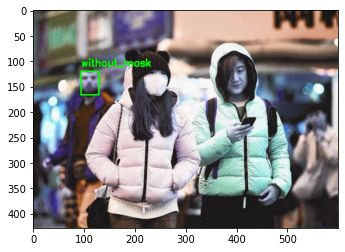

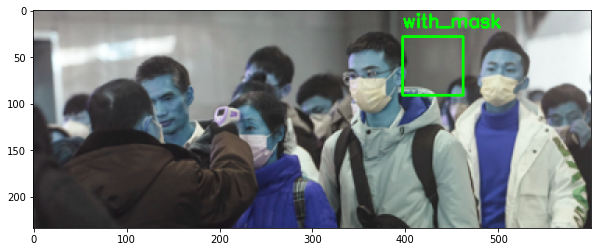

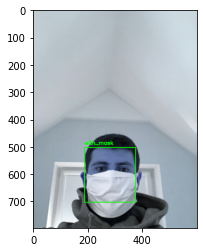

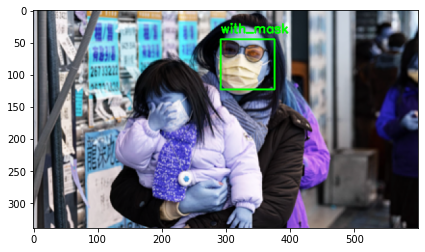

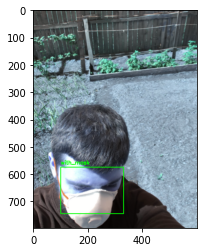

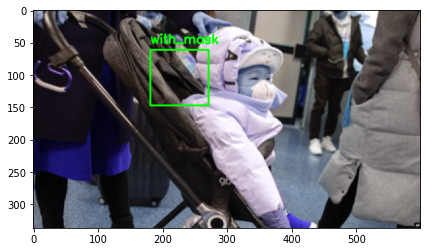

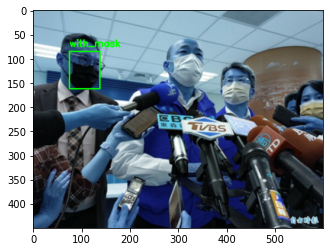

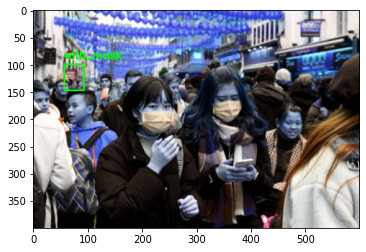

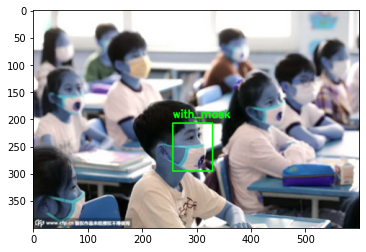

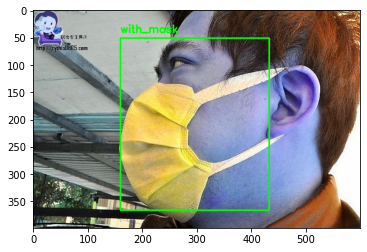

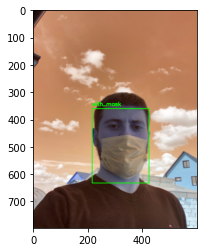

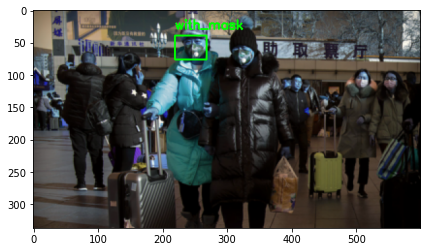

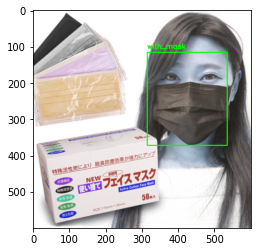

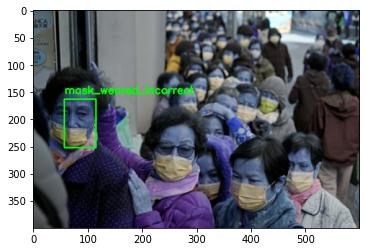

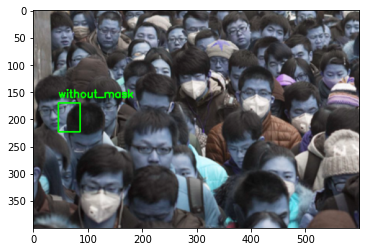

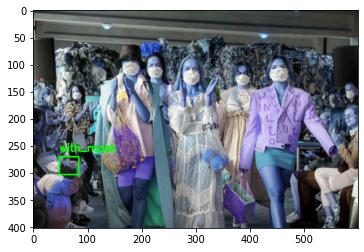

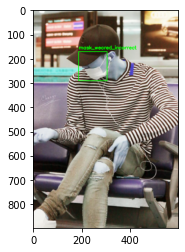

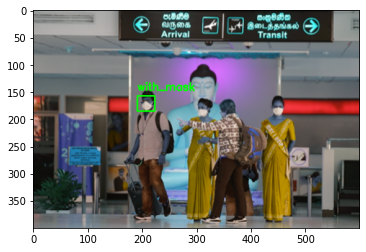

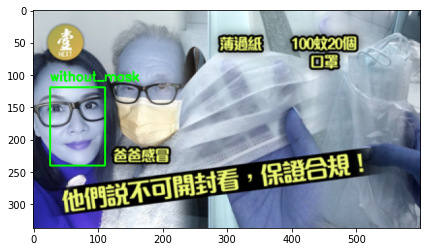

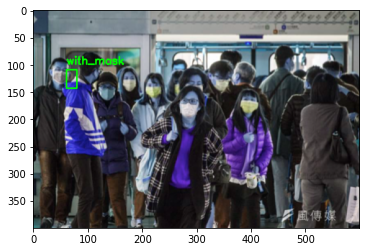

In [17]:
for imagePath in image_paths[:20]:
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    # predict the bounding box of the object along with the class
    # label
    (boxPreds, labelPreds) = model.predict(image)
    (startX, startY, endX, endY) = boxPreds[0]
    # determine the class label with the largest predicted
    # probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]
        # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    plt.subplots(figsize = (14,4))
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    # draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (0, 255, 0), 2)
    cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)
    # show the output image
    plt.imshow(image)
    
    